In [1]:
#Error analysis and Explainaibility
import pandas as pd
import numpy as np
import torch
import random
import numpy as np

from transformers import AutoTokenizer, BertForMaskedLM 
from datasets import load_dataset, Dataset, DatasetDict
from matplotlib import pyplot as plt
import pickle

In [2]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
device

device(type='cpu')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = BertForMaskedLM.from_pretrained("bert-base-cased")

def get_probs(sentence, word_idx):
    input_ids = tokenizer.encode(sentence)
    input_ids = torch.tensor([input_ids])
    logits = bert(input_ids)[0][0]
    sorted_probs = logits[word_idx].sort(descending=True)

    return sorted_probs

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
sentence = f"We want to go to {tokenizer.mask_token}."
sorted_probs = get_probs(sentence, 6)
for i in range(10):
    token = tokenizer._convert_id_to_token(sorted_probs.indices[i].numpy().tolist())
    conf = sorted_probs.values[i].detach().numpy().tolist()
    print(f"{token}: {conf}")

sleep: 8.723100662231445
hell: 8.661073684692383
school: 8.478261947631836
bed: 8.442703247070312
work: 8.129664421081543
heaven: 8.072664260864258
church: 8.0494966506958
college: 7.654545307159424
Italy: 7.634221076965332
her: 7.583528995513916


In [6]:
import spacy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix


2022-10-27 17:14:31.579934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 17:14:32.154979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 17:14:32.155018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-27 17:14:32.227161: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-27 17:14:33.508046: W tensorflow/stream_executor/platform/de

In [7]:
dataset = load_dataset("copenlu/answerable_tydiqa")

#split data 
train_set = dataset["train"]
validation_set = dataset["validation"]

train_set = train_set.to_pandas()
validation_set = validation_set.to_pandas()

#preprocess data

eng_train_set = train_set[train_set['language'] == 'english']
fin_train_set = train_set[train_set['language'] == 'finnish']
jap_train_set = train_set[train_set['language'] == 'japanese']

eng_validation_set = validation_set[validation_set['language'] == 'english']
fin_validation_set = validation_set[validation_set['language'] == 'finnish']
jap_validation_set = validation_set[validation_set['language'] == 'japanese']


Using custom data configuration copenlu--nlp_course_tydiqa-cceecfb5416d988a
Found cached dataset parquet (/home/gadelampe/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-cceecfb5416d988a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [47]:
current_language = 'eng'

# import training data
eng_train_set = pd.read_csv('../../data/dft_'+current_language+'.csv')

# import validation data
eng_validation_set = pd.read_csv('../../data/dfv_'+current_language+'.csv')

In [8]:
eng_train_set

,question_text,document_title,language,annotations,document_plaintext,document_url
26,When was quantum field theory developed?,Quantum field theory,english,"{'answer_start': [159], 'answer_text': ['1920s']}",Quantum field theory naturally began with the ...,https://en.wikipedia.org/wiki/Quantum%20field%...
43,Who was the first Nobel prize winner for Liter...,List of Nobel laureates in Literature,english,"{'answer_start': [610], 'answer_text': ['Sully...",The Nobel Prize in Literature (Swedish: Nobelp...,https://en.wikipedia.org/wiki/List%20of%20Nobe...
112,When is the dialectical method used?,Dialectic,english,"{'answer_start': [129], 'answer_text': ['disco...","Dialectic or dialectics (Greek: διαλεκτική, di...",https://en.wikipedia.org/wiki/Dialectic
123,Who invented Hangul?,Origin of Hangul,english,"{'answer_start': [88], 'answer_text': ['Sejong...",Hangul was personally created and promulgated ...,https://en.wikipedia.org/wiki/Origin%20of%20Ha...
125,What do Grasshoppers eat?,Grasshopper,english,"{'answer_start': [0], 'answer_text': ['Grassho...","Grasshoppers are plant-eaters, with a few spec...",https://en.wikipedia.org/wiki/Grasshopper
...,...,...,...,...,...,...
116000,What was Neil Brooks' fastest recorded time?,Swimming at the 1980 Summer Olympics – Men's 4...,english,"{'answer_start': [-1], 'answer_text': ['']}",The medley relay was scheduled in the Olympisk...,https://en.wikipedia.org/wiki/Swimming%20at%20...
116012,Who are the three most important eastern philo...,Eastern philosophy,english,"{'answer_start': [-1], 'answer_text': ['']}",Sāmkhya is a dualist philosophical tradition b...,https://en.wikipedia.org/wiki/Eastern%20philos...
116027,Who was costume designer for the first Star Wa...,John Mollo,english,"{'answer_start': [-1], 'answer_text': ['']}",Mollo was surprised by the success of Star War...,https://en.wikipedia.org/wiki/John%20Mollo
116055,Who developed the first thermonuclear weapon?,History of nuclear weapons,english,"{'answer_start': [-1], 'answer_text': ['']}","In the end, President Truman made the final de...",https://en.wikipedia.org/wiki/History%20of%20n...


In [9]:
def get_answerability(annotations):
    answerable = []
    for annot in annotations:
        if -1 in annot['answer_start']:
            answerable.append(0)
        else:
            answerable.append(1)
    return answerable

# def get_answerability(annotations):
#     answerable = []
#     for annot in annotations:
#         if '-' in annot[24]:
#             answerable.append(0)
#         else:
#             answerable.append(1)
#     return answerable


eng_train_set['answerable'] = get_answerability(eng_train_set['annotations'].tolist())
# fin_train_set['answerable'] = get_answerability(fin_train_set['annotations'].tolist())
# jap_train_set['answerable'] = get_answerability(jap_train_set['annotations'].tolist())

eng_validation_set['answerable'] = get_answerability(eng_validation_set['annotations'].tolist())
# fin_validation_set['answerable'] = get_answerability(fin_validation_set['annotations'].tolist())
# jap_validation_set['answerable'] = get_answerability(jap_validation_set['annotations'].tolist())

/tmp/ipykernel_10548/371622846.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_train_set['answerable'] = get_answerability(eng_train_set['annotations'].tolist())
/tmp/ipykernel_10548/371622846.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_validation_set['answerable'] = get_answerability(eng_validation_set['annotations'].tolist())


In [10]:
eng_train_set.columns

Index(['question_text', 'document_title', 'language', 'annotations',
       'document_plaintext', 'document_url', 'answerable'],
      dtype='object')

In [ ]:
from nltk.tokenize import WordPunctTokenizer, TreebankWordTokenizer, RegexpTokenizer

# punct = WordPunctTokenizer()
# tree = TreebankWordTokenizer()
reg = RegexpTokenizer('\w+[\'\-+]?\w*|\[\d+\]')
# reg = RegexpTokenizer('\w+[\'\-+]?\w*|[1-9]\d{0,2}(,\d{3})*(\.\d+)?|\[\d+\]')

eng_train_set['answer_tokens'] = [reg.tokenize(i) for i in eng_train_set.answer_text.values]
eng_validation_set['answer_tokens'] = [reg.tokenize(i) for i in eng_validation_set.answer_text.values]
eng_train_set['tokens'] = [reg.tokenize(i) for i in eng_train_set.document_plaintext.values]
eng_validation_set['tokens'] = [reg.tokenize(i) for i in eng_validation_set.document_plaintext.values]

### Functions to create BoW vectors

In [77]:
def make_bow_vector(sentence, countt):
    vec = np.zeros(len(countt))
    for word in sentence:
        vec[countt[word]] += 1
    return vec

def ans_freq(que, doc):

    freq = [x for x in que if x in doc]
    freq = len(freq)/len(que)
    return freq

def freq_words_in_text (df_t,df_v):
    for df in [df_t,df_v]:
        frequency = []
        for question, answer in zip(df['question_text_tokenized'], df['document_plaintext_tokenized']):
            frequency.append(ans_freq(eval(question), eval(answer)))

        df['word_frequency_score'] = frequency

### Combine and flatten

In [78]:
t_comb2 = [str(que)+ " "+ str(doc) for que, doc in zip(eng_train_set["question_text"],eng_train_set["document_plaintext"])]
v_comb2 = [str(que)+ " "+ str(doc) for que, doc in zip(eng_validation_set["question_text"],eng_validation_set["document_plaintext"])]

In [79]:
t_comb2.extend(v_comb2)

In [80]:
CountVec = CountVectorizer(ngram_range=(1,1))
Count_data = CountVec.fit_transform(t_comb2)

In [81]:
freq_words_in_text(eng_train_set,eng_validation_set)

In [82]:
ct = Count_data.toarray()[:len(eng_train_set)]
cv = Count_data.toarray()[len(eng_train_set):]

In [84]:
# ct = [l.tolist() for l in Count_data.toarray()[:len(eng_train_set)]]
cv = [l.tolist() for l in Count_data.toarray()[len(eng_train_set):]]

In [85]:
t_wf = eng_train_set['word_frequency_score'].values
v_wf = eng_validation_set['word_frequency_score'].values

In [86]:
# xt = []
# for index in range(len(dft)):
#     xt.append(np.append(t_wf[index],ct[index]))
    
xv = []
for index in range(len(eng_validation_set)):
    xv.append(np.append(v_wf[index],cv[index]))

In [87]:
# X_train = np.array(xt)
X_val = np.array(xv)
y_train = eng_train_set.label.values
y_val = eng_validation_set.label.values
X_val.shape

(990, 52691)

In [90]:
eng_validation_set.columns

Index(['question_text', 'document_title', 'language', 'annotations',
       'document_plaintext', 'document_url', 'question_text_tokenized',
       'document_plaintext_tokenized', 'label', 'word_frequency_score',
       'logres_pred', 'answerable'],
      dtype='object')

In [11]:
def question_parag_combine(questions, paragraphs):
    """
    This function combines the questions and paragraphs into a single text
    Args:
        questions: list of questions
        paragraphs: list of paragraphs
    Returns:
        list of combined questions and paragraphs
    """
    training_data = []
    for index in range(len(questions)):
        training_data += [questions[index] + "\n" + paragraphs[index]]
        
    return training_data

def make_df(train_set, validation_set):
    d_q = train_set['question_text'].tolist()
    d_p = train_set['document_plaintext'].tolist()
    training_data = question_parag_combine(d_q,d_p)
    training_labels = train_set['answerable'].tolist()

    d_q = validation_set['question_text'].tolist()
    d_p = validation_set['document_plaintext'].tolist()
    validation_data = question_parag_combine(d_q,d_p)
    validation_labels = validation_set['answerable'].tolist()



    data_set = {}
    sets = [['train',training_data, training_labels], ['val', validation_data, validation_labels]]
    for meta in sets:
        data_set[meta[0]] = {}
        data_set[meta[0]]['text'] = []
        data_set[meta[0]]['labels'] = []

        for ind, text in enumerate(meta[1]):
            data_set[meta[0]]['text'].append(text)
            data_set[meta[0]]['labels'].append(meta[2][ind])

          

          
    data_set = DatasetDict({'train':Dataset.from_dict(data_set['train']),
                          'valid':Dataset.from_dict(data_set['val'])\
                        })
    return data_set

eng_set = make_df(eng_train_set, eng_validation_set)
# fin_set = make_df(fin_train_set, fin_validation_set)
# jap_set = make_df(jap_train_set, jap_validation_set)

eng_set

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 7389
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 990
    })
})

In [12]:
train_set = eng_set['train']
val_set = eng_set['valid']

In [13]:
n = 100

#print(dft_eng['document_plaintext'].values)
vectorizer = TfidfVectorizer(max_features=10000)
features = vectorizer.fit_transform(train_set['text'])
# the raw/textual n-grams the vectorizer is using
feature_array = np.array(vectorizer.get_feature_names_out())
# TF-IDF scores of the words in each instance of the input datasets
tfidf_sorting = np.argsort(features.toarray()).flatten()[::-1]

# With a TF-IDF Vecotrizer, we can already tell the words that have high TF-IDF scores
# Even before feeding them to the model:
# Look-up of the top-n words at the indices with 1) highest and 2) lowest scores 
print(feature_array[tfidf_sorting][:2])
print(feature_array[tfidf_sorting][-2:])

['recall' 'mayor']
['papal' '00']


In [15]:
train_set['text'][:3]

['When was quantum field theory developed?\nQuantum field theory naturally began with the study of electromagnetic interactions, as the electromagnetic field was the only known classical field as of the 1920s.[8]:1',
 "Who was the first Nobel prize winner for Literature?\nThe Nobel Prize in Literature (Swedish: Nobelpriset i litteratur) is awarded annually by the Swedish Academy to authors for outstanding contributions in the field of literature. It is one of the five Nobel Prizes established by the 1895 will of Alfred Nobel, which are awarded for outstanding contributions in chemistry, physics, literature, peace, and physiology or medicine.[1] As dictated by Nobel's will, the award is administered by the Nobel Foundation and awarded by a committee that consists of five members elected by the Swedish Academy.[2] The first Nobel Prize in Literature was awarded in 1901 to Sully Prudhomme of France.[3] Each recipient receives a medal, a diploma and a monetary award prize that has varied t

In [41]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100)
features = vectorizer.fit_transform(train_set['text'])
# training a linear model, which is interpretable by design
lr = LogisticRegression(penalty='l2', max_iter=1000, multi_class='ovr')
lr.fit(features, train_set['labels'])

LogisticRegression(max_iter=1000, multi_class='ovr')

In [42]:
#features_test = vectorizer.fit_transform(dfv_eng.values[:, 0])
#preds_tfidf = lr.predict(features_test)

In [43]:
features_valid = vectorizer.transform(val_set['text'])
preds_valid_tfidf = lr.predict(features_valid)

In [44]:
from tqdm import tqdm
import nltk

In [45]:
from bpemb import BPEmb

# Load english model with 25k word-pieces
bpemb_en = BPEmb(lang='en', dim=100, vs=25000)

In [46]:
def get_bpemb_features(dataset, bpemb):
  # With bpemb we can tokenize and embed an entire document using .embed(x)
  X = [bpemb.embed(x).mean(0) for x in tqdm(dataset['text'])]
  y = dataset['labels']
 
  return X,y

In [47]:
X_train,y_train = get_bpemb_features(train_set, bpemb_en)
X_valid,y_valid = get_bpemb_features(val_set, bpemb_en)
lr_bpemb = LogisticRegression(penalty='l2', max_iter=1000, multi_class='ovr')
lr_bpemb.fit(X_train, y_train)

100%|██████████| 990/990 [00:00<00:00, 1701.49it/s]


LogisticRegression(max_iter=1000, multi_class='ovr')

In [48]:
#preds_bpemb = lr_bpemb.predict(X_test)
preds_valid_bpemb = lr_bpemb.predict(X_valid)
# preds_valid_bpemb

In [65]:
current_language = 'eng'
filename = '../../models/logres_model_'+current_language+'.sav'

loaded_model = pickle.load(open(filename, 'rb'))

In [49]:
eng_biLSTM_meta_preds = np.array([
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [67]:
loaded_model.predict(features_valid)

ValueError: X has 100 features, but LogisticRegression is expecting 52390 features as input.

In [50]:
# TF-IDF model 
y_valid = val_set['labels']
report = classification_report(y_valid, preds_valid_tfidf, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.689805,0.642424,0.665272,495.000000
1,0.665406,0.711111,0.687500,495.000000
accuracy,0.676768,0.676768,0.676768,0.676768
macro avg,0.677606,0.676768,0.676386,990.000000
weighted avg,0.677606,0.676768,0.676386,990.000000


In [51]:
# BPEmb model 
report = classification_report(y_valid, preds_valid_bpemb, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.694624,0.652525,0.672917,495.000000
1,0.672381,0.713131,0.692157,495.000000
accuracy,0.682828,0.682828,0.682828,0.682828
macro avg,0.683502,0.682828,0.682537,990.000000
weighted avg,0.683502,0.682828,0.682537,990.000000


In [52]:
# English bi-LSTM model with meta-features 
report = classification_report(y_valid, eng_biLSTM_meta_preds, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.612698,0.389899,0.476543,495.000000
1,0.552593,0.753535,0.637607,495.000000
accuracy,0.571717,0.571717,0.571717,0.571717
macro avg,0.582646,0.571717,0.557075,990.000000
weighted avg,0.582646,0.571717,0.557075,990.000000


In [53]:
confusion_matrix(val_set['labels'], preds_valid_tfidf)


array([[318, 177],
       [143, 352]])

In [54]:
confusion_matrix(val_set['labels'], preds_valid_bpemb)

array([[323, 172],
       [142, 353]])

In [55]:
confusion_matrix(val_set['labels'], eng_biLSTM_meta_preds)

array([[193, 302],
       [122, 373]])

0


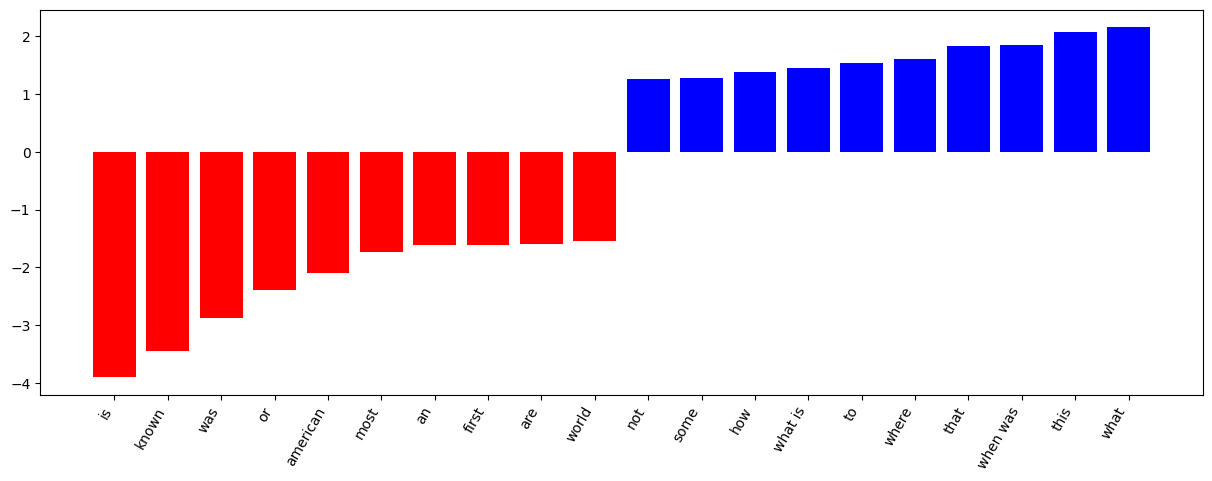

1


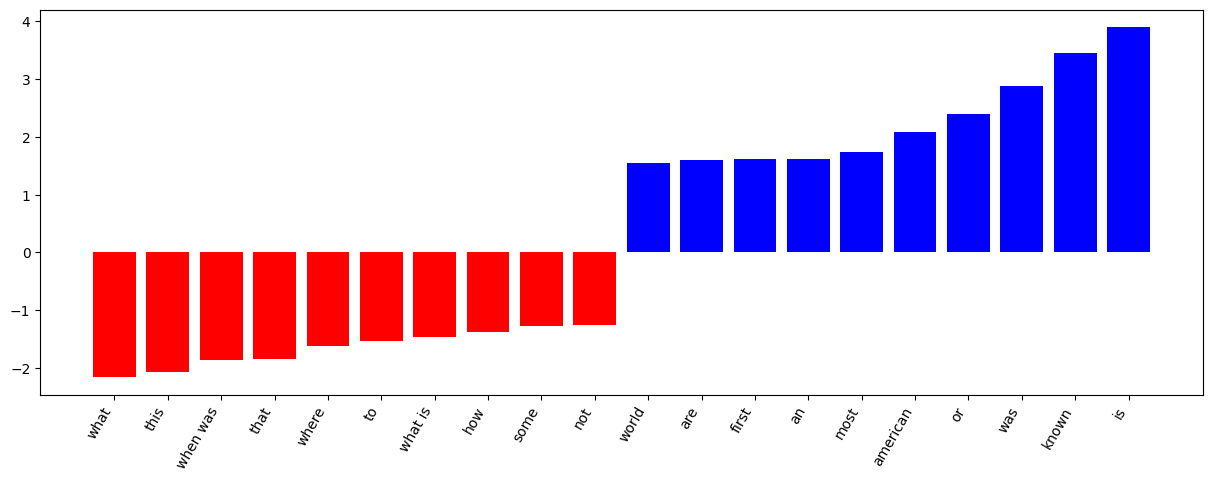

In [56]:
top_features = 10
# get the model's weights: n_classes x n_features - (? , ?)
all_class_coef = lr.coef_

for i, cls in enumerate(lr.classes_): # for each of the classes
  print(cls)
  # get the weights for the class
  coef = all_class_coef[0]
  if cls == 0:
    coef = -coef
  # find the top negative and positive features for the class
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  # combine them in one array
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot - humans tend to understand better plot visualizations
  feature_names = vectorizer.get_feature_names_out()
  plt.figure(figsize=(15, 5))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  plt.show()

### Error classification

In [57]:
X_valid[0].shape

(100,)

In [58]:
# get the probability of the chosen model
valid_pred_prob = lr.predict_proba(X_valid)

In [59]:
test_val_set = val_set.to_pandas()

test_val_set

,text,labels
0,What is a way to increase your wound healing s...,1
1,Who founded the Burntisland Shipbuilding Compa...,1
2,What is the surface area of the human cortex?\...,1
3,When did the case of R (Factortame Ltd) v Secr...,1
4,When was Quezon City founded?\nWhen Quezon Cit...,1
...,...,...
985,What's the average income in West Virginia?\nN...,0
986,How often do LSAT tests take place?\nA recent ...,0
987,How much does a bushel of barley weigh?\n\nThe...,0
988,What is the most common first word by babies?\...,0


In [61]:
from collections import defaultdict

# collect correct and wrong predictions, keeping the confidence of the prediction
errors = defaultdict(lambda: [])
correct_preds = defaultdict(lambda: [])

for (i, instance), pred, pred_score in zip(test_val_set.iterrows(), preds_valid_tfidf, valid_pred_prob):
  # get the index/id of the gold class in the probability array (n_classes x 1)
  index_of_class = np.where(lr.classes_ == instance[1])
  # get the index/id of the predicted class in the probability array (n_classes x 1)
  index_of_pred_class =  np.where(lr.classes_ == pred)
  # depending on whether the prediction is correct, collect the instances as errors or correct predictions
  # index 1 is the label or answerability, index 0 is the text
  if pred != instance[1]:
    errors[instance[1]].append((instance[0], pred_score[index_of_class], pred_score[index_of_pred_class], pred))
  else:
    correct_preds[instance[1]].append((instance[0], pred_score[index_of_class], pred_score, pred))

In [62]:
import pprint

for cls in lr.classes_:
  print('Answerability = ', cls)
  print('High probability for correct class')
  # sort the errors by the probability of the gold class and look at the:
  # 1. instances where the gold class had a high probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[-10:])
  print()
  print('Answerability = ', cls)
  print('Low probability for correct class')
  # 1. instances where the gold class had a low probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[:10])
  print()
  print()

Answerability =  0
High probability for correct class
[('When was the first computer invented?\n'
  'Early computing machines had fixed programs. Changing its function required '
  'the re-wiring and re-structuring of the machine.[30] With the proposal of '
  'the stored-program computer this changed. A stored-program computer '
  'includes by design an instruction set and can store in memory a set of '
  'instructions (a program) that details the computation. The theoretical '
  'basis for the stored-program computer was laid by Alan Turing in his 1936 '
  'paper. In 1945, Turing joined the National Physical Laboratory and began '
  'work on developing an electronic stored-program digital computer. His 1945 '
  'report "Proposed Electronic Calculator" was the first specification for '
  'such a device. John von Neumann at the University of Pennsylvania also '
  'circulated his First Draft of a Report on the EDVAC in 1945.[20]',
  array([0.99859546]),
  array([0.00140454]),
  1),
 ('Wh

In [63]:
# We can check for some instances what were their TF-IDF scores (the input for the model)
text = 'As of November2015, Greater Adelaide had an unemployment rate of 7.4% with'
print(vectorizer.transform([text]))
text = 'As of November2015, Greater Adelaide had an unemployment rate of 7.4% with'
print([word for word in text.lower().split() if word in vectorizer.vocabulary_])

  (0, 96)	0.384181001824668
  (0, 52)	0.4437114776199105
  (0, 29)	0.5794982785374934
  (0, 10)	0.34720675637562715
  (0, 6)	0.44626706798121196
['as', 'of', 'had', 'an', 'of', 'with']


In [64]:
# do the same for correct predictions
for cls in lr.classes_:
  print('Answerability = ', cls)
  print('High probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[-10:])
  print()
  print('Answerability = ', cls)
  print('Low probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[:10])
  print()
  print()

Answerability =  0
High probability for correct class
[("When was the Republican People's Party formed in Turkey?\n"
  'But the Welfare Party was banned in 1998, and during the 1990s the '
  'Democratic Left Party led by former CHP leader Bülent Ecevit gained popular '
  'support. In 1998, after the resignation of the Refah-DYP coalition '
  'following the 28 February "post-modern coup", ANAP formed a coalition '
  'government with the DSP and the small centre-right party Democratic Turkey '
  'Party (DTP), along with the support of CHP.',
  array([0.99871733]),
  array([0.99871733, 0.00128267]),
  0),
 ('When was Florida founded?\n'
  'A majority of the people who bought land in Florida hired intermediaries to '
  'accomplish the transactions. By 1924, the main issues in state elections '
  'were how to attract more industry and the need to build and maintain good '
  'roads for tourists.[69] During the time frame, the population grew from '
  'less than one million in 1920, to 1,263,